In [16]:
import pandas as pd

root_dir = ''
image_dir = 'final_cxr_dataset/'

df = pd.read_csv('final_dataset.csv')

0.348116361741717 0.9539819773255013


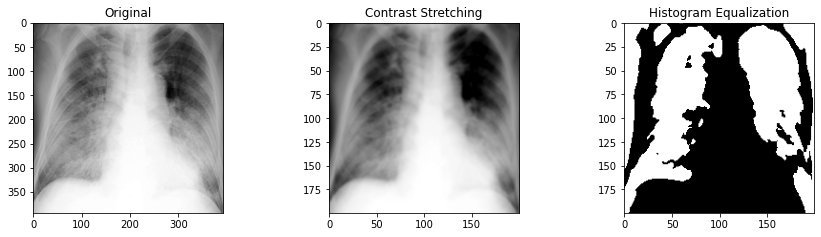

In [97]:
import numpy as np
from skimage import io, filters, exposure
from matplotlib import pyplot as plt
from skimage.transform import resize
from skimage import img_as_ubyte
import skimage.exposure as expo

length = 200
index = 4

current = df.iloc[index]
img_loc = root_dir + image_dir + current['filename']

#coarse_mask = img_as_ubyte(io.imread('coarse_mask.png', as_gray=True))

try:
    img = orig_img = img_as_ubyte(io.imread(img_loc, as_gray=True))
    y_len, x_len = img.shape
    
    if y_len > x_len:    # height > width
        img = resize(img, [ round(length*y_len/x_len), length ])
        y_len = img.shape[0]
        crop_length = y_len - length
        img = img[ :y_len-crop_length , : ]    # crop from bottom
        
    elif y_len < x_len:    # height < width
        
        img = resize(img, [ length, round(length*x_len/y_len) ])
        x_len = img.shape[1]
        crop_length = x_len - length
        half_crop = crop_length//2
        img = img[ : , half_crop:x_len-half_crop ]    # crop on left and right
        
        if img.shape[0] != img.shape[1]:
            img = img[ : , :length ]    # make sure image is square
        
    else:    # height == width
        img = resize(img, [ length, length ])
    
    img = filters.gaussian(img)
    
    #contrast stretching
    p2, p98 = np.percentile(img, (2, 98))
    img = exposure.rescale_intensity(img, in_range=(p2, p98))
    print(p2, p98)
    
    #histogram eq
    #img = exposure.equalize_hist(img)
    
    #adaptive histogram eq
    img_eq = exposure.equalize_adapthist(img, clip_limit=0.01)
    
    # coarse mask -> thresholding
    inverted = ~img_as_ubyte(img_eq)
    thresh = filters.threshold_otsu(inverted)
    #thresh = filters.threshold_multiotsu(img_eq)
    #regions = np.digitize(img_eq, bins=thresh)
    
    binary1 = inverted >= thresh
    #plt.imshow(binary1, cmap="gray")
    
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(15, 3.5))
    ax0.set_title("Original")
    ax1.set_title("Contrast Stretching")
    ax2.set_title("Histogram Equalization")
    
    ax0.imshow(orig_img, cmap="gray")
    ax1.imshow(img, cmap="gray")
    ax2.imshow(binary1, cmap="gray")
    #ax3.imshow(regions, cmap="gray")
    
except FileNotFoundError:
    print(f'{img_loc} not found.')

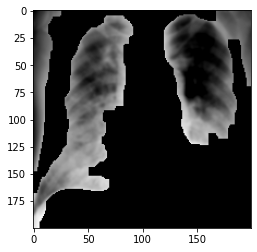

In [98]:
from skimage.morphology import square, dilation, erosion, opening, closing, remove_small_objects, remove_small_holes
#coarse mask -> thresholding
#masked = ~(img_as_ubyte(img) * coarse_mask)
#thresh = flt.threshold_yen(masked)
#binary1 = masked <= thresh

# thresholding -> coarse mask
#thresh = flt.threshold_yen(img_as_ubyte(img))
#masked = ~(img_as_ubyte(img) * coarse_mask)
#binary2 =  masked <= thresh

kernel = square(7)
op = opening(binary1, kernel)#select binary here
op = dilation(remove_small_objects(erosion(op, kernel), 500), kernel)
mask = closing(op, kernel)
mask = remove_small_objects(mask, 1500)
mask = remove_small_holes(mask, 1000)
final1 = img * mask

plt.imshow(final1, cmap=plt.cm.gray)

In [10]:
"""
output_dir = 'preprocessed/'
img_dir = 'masked_images/'
mask_dir = 'masks/'
filename = f'{index}.png'

try:
    io.imsave(f'{output_dir}{img_dir}{filename}', img_as_ubyte(final1))
    io.imsave(f'{output_dir}{mask_dir}{filename}', img_as_ubyte(mask))
    print('Success')
finally:
    print('DONE')
"""

"\noutput_dir = 'preprocessed/'\nimg_dir = 'masked_images/'\nmask_dir = 'masks/'\nfilename = f'{index}.png'\n\ntry:\n    io.imsave(f'{output_dir}{img_dir}{filename}', img_as_ubyte(final1))\n    io.imsave(f'{output_dir}{mask_dir}{filename}', img_as_ubyte(mask))\n    print('Success')\nfinally:\n    print('DONE')\n"

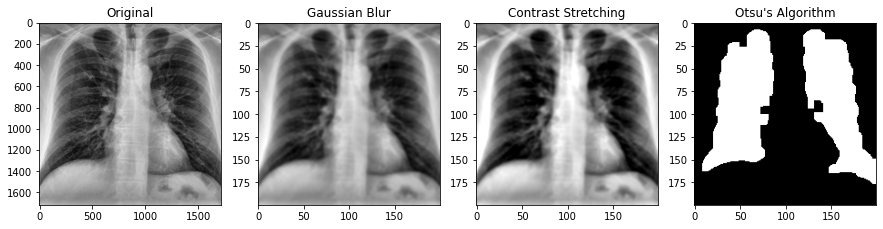

In [11]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=4, figsize=(15, 3.5))
ax0.set_title("Original")
ax1.set_title("Gaussian Blur")
ax2.set_title("Contrast Stretching")
ax3.set_title("Otsu's Algorithm")

ax0.imshow(orig_img, cmap="gray")
ax1.imshow(img, cmap="gray")
ax2.imshow(img_rescale, cmap="gray")
ax3.imshow(mask, cmap="gray")
#ax3.imshow(regions, cmap="gray")

In [12]:
ax0.imshow(orig_img, cmap="gray")
ax1.imshow(img, cmap="gray")

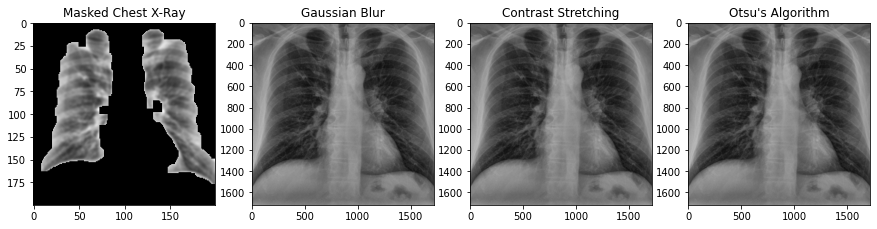

In [13]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=4, figsize=(15, 3.5))
ax0.set_title("Masked Chest X-Ray")
ax1.set_title("Gaussian Blur")
ax2.set_title("Contrast Stretching")
ax3.set_title("Otsu's Algorithm")

ax0.imshow(final1, cmap="gray")
ax1.imshow(img_as_ubyte(io.imread(img_loc)))
ax2.imshow(img_as_ubyte(io.imread(img_loc)))
ax3.imshow(img_as_ubyte(io.imread(img_loc)))

In [30]:
length = 200
i = 39
current = df.iloc[i]
img_loc = root_dir + image_dir + current['filename']

try:
    img = img_as_ubyte(io.imread(img_loc, as_gray=True))
    y_len, x_len = img.shape

    if y_len > x_len:    # height > width
        img = resize(img, [ round(length*y_len/x_len), length ])
        y_len = img.shape[0]
        crop_length = y_len - length
        img = img[ :y_len-crop_length , : ]    # crop from bottom

    elif y_len < x_len:    # height < width

        img = resize(img, [ length, round(length*x_len/y_len) ])
        x_len = img.shape[1]
        crop_length = x_len - length
        half_crop = crop_length//2
        img = img[ : , half_crop:x_len-half_crop ]    # crop on left and right

        if img.shape[0] != img.shape[1]:
            img = img[ : , :length ]    # make sure image is square

    else:    # height == width
        img = resize(img, [ length, length ])

    img = filters.gaussian(img)
except FileNotFoundError:
    print(f'{img_loc} not found.')

# CONTRAST STRETCHING + HISTOGRAM EQUALIZTIONA
p2, p98 = np.percentile(img, (2, 98))
img = exposure.rescale_intensity(img, in_range=(p2, p98))
#img = exposure.equalize_hist(img)

inverted = ~img_as_ubyte(img)
thresh = filters.threshold_otsu(inverted)
binary1 = inverted >= thresh

#thresh = filters.threshold_multiotsu(img)
#binary1 = ~(img >= thresh[0])

kernel = square(7)
op = p_op = opening(binary1, kernel)#select binary here
op = dilation(remove_small_objects(erosion(op, kernel), 200), kernel)
mask = p_mask = closing(op, kernel)
mask = p2_mask = remove_small_objects(mask, 1000)
mask = p3_mask = remove_small_holes(mask, 1000)
final1 = img * mask

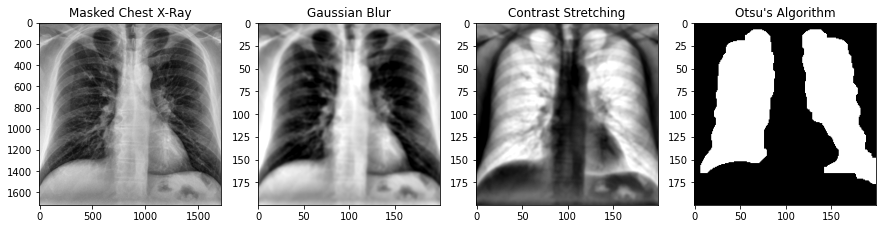

In [31]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=4, figsize=(15, 3.5))
ax0.set_title("Masked Chest X-Ray")
ax1.set_title("Gaussian Blur")
ax2.set_title("Contrast Stretching")
ax3.set_title("Otsu's Algorithm")

ax0.imshow(orig_img, cmap="gray")
ax1.imshow(img, cmap="gray")
ax2.imshow(inverted, cmap="gray")
ax3.imshow(mask, cmap="gray")

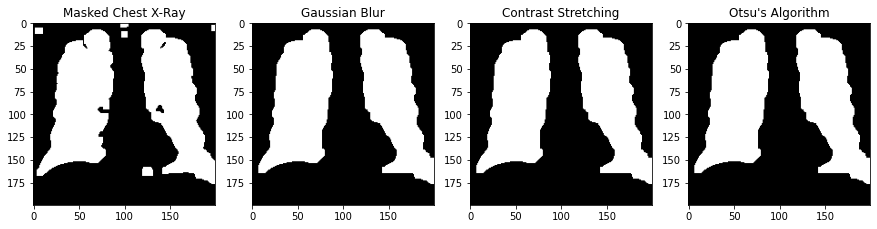

In [32]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=4, figsize=(15, 3.5))
ax0.set_title("Masked Chest X-Ray")
ax1.set_title("Gaussian Blur")
ax2.set_title("Contrast Stretching")
ax3.set_title("Otsu's Algorithm")

ax0.imshow(p_op, cmap="gray")
ax1.imshow(p_mask, cmap="gray")
ax2.imshow(p2_mask, cmap="gray")
ax3.imshow(p3_mask, cmap="gray")

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
196,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
197,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
198,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
